In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np
import xlsxwriter
import re

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
import sys
sys.path.append(f'../../src/python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, get_feature_importance, get_feature_importance10, eval_matrix

### Load data

In [18]:
df = pd.read_json(r"../../data/processed/pre-processed_merged_2023_04_04.json")

In [19]:
# Define a regular expression pattern to match the unwanted words
remove_words = ['dg comp merger registry', 'belgië', 'tel fax mail', 'tel', 'fax', 'comp merger registry',
                'ec europa eu', 'belgië fax', 'comp merger registry', 'tel', 'tel fax', 'fax mail', 'registry fax']
remove_pattern = re.compile(r'\b(' + '|'.join(remove_words) + r')\b', flags=re.IGNORECASE)
df['text_clean'] = df['text_clean'].replace(remove_pattern, '', regex=True)

### Balance data and split to train and test set

In [20]:
label_name = "phase2"
random_seed=1
random_state=1

In [21]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded, text='text_clean')

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 1    98
0    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 79 0: 79
Creating df_test1 1: 20 0: 21
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1407
Grouping df_train by case_num 1: 79 0: 79
Grouping df_test by case_num 1: 20 0: 1407
Grouping df_test1 by case_num 1: 20 0: 21
Grouping df_excluded by case_num with len: 1386


In [22]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped, text='text_clean')

### Model training (with 10-fold CV) using best parameters from GridSearch

In [23]:
# lowercase, remove stopwords
vec_0 = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=True, stop_words='english', \
                                  ngram_range = (2,2), binary = True, max_df = 0.025, norm = 'l1', use_idf = False))
c_0 = 1
model_0 = LinearSVC(C=c_0)

# lowercase, retain stopwords
vec_1 = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=True, stop_words=None, \
                                  ngram_range = (1,3), binary = True, max_df = 0.05, norm = 'l2', use_idf = True))
c_1 = 0.1
model_1 = LinearSVC(C=c_1)

In [24]:
df_metrics = pd.DataFrame(columns = ['set', 'vec', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [25]:
for i in range(0,2):    
    # balanced train
    globals()[f"pipeline_train_{i}"], globals()[f"trained_model_{i}"], globals()[f"y_predict_train_{i}"] = train_model_cross_val(X_train, y_train, vec=globals()[f"vec_{i}"], model=globals()[f"model_{i}"], cv=10)
    globals()[f"df_features_train_{i}"], _, _ = get_feature_importance(globals()[f"trained_model_{i}"], globals()[f"pipeline_train_{i}"])    
    set = "balanced train"
    metrics_train=evaluate(y_train, globals()[f"y_predict_train_{i}"])
    row_train = pd.DataFrame({'set':set, 'vec':i, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                        'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                        'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])

    # balanced test
    _, globals()[f"y_predict_test1_{i}"] = train_model_test(X_train, y_train, X_test1, y_test1, model=globals()[f"model_{i}"], vec=globals()[f"vec_{i}"])
    set = "balanced test"
    metrics_test1=evaluate(y_test1, globals()[f"y_predict_test1_{i}"])
    row_test1 = pd.DataFrame({'set':set, 'vec':i, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                            'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                            'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])

    # imbalanced test
    _, globals()[f"y_predict_test_{i}"] = train_model_test(X_train, y_train, X_test, y_test, model=globals()[f"model_{i}"], vec=globals()[f"vec_{i}"])
    set = "imbalanced test"
    metrics_test=evaluate(y_test, globals()[f"y_predict_test_{i}"])
    row_test = pd.DataFrame({'set':set, 'vec':i, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                        'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                        'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

    df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)
    df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.6392405063291139

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.32      0.47        79
           1       0.58      0.96      0.73        79

    accuracy                           0.64       158
   macro avg       0.74      0.64      0.60       158
weighted avg       0.74      0.64      0.60       158


CR: (0.7387362637362638, 0.639240506329114, 0.5972812234494478, None)

Confusion matrix:
 [[25 54]
 [ 3 76]] 

_______________________


 Accuracy: 63.924 
 Precision: 0.585 
 Recall: 0.962 
 F1: 0.727 
 FPR: 0.684 
 ROC_AUC: 0.639
Accuracy: 0.6392405063291139

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.32      0.47        79
           1       0.58      0.96      0.73        79

    accuracy                           0.64       158
   macro avg       0.74      0.64      0.60       158
weighted avg       0.74      

In [26]:
df_metrics

,set,vec,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,0,25,54,3,76,0.962025,0.584615,0.727273,0.683544,63.924051,0.639241,158
1,balanced test,0,4,17,0,20,1.000000,0.540541,0.701754,0.809524,58.536585,0.595238,41
2,imbalanced test,0,331,1076,0,20,1.000000,0.018248,0.035842,0.764748,24.597057,0.617626,1427
3,balanced train,1,71,8,11,68,0.860759,0.894737,0.877419,0.101266,87.974684,0.879747,158
4,balanced test,1,21,0,5,15,0.750000,1.000000,0.857143,0.000000,87.804878,0.875000,41
5,imbalanced test,1,1318,89,5,15,0.750000,0.144231,0.241935,0.063255,93.412754,0.843372,1427


In [27]:
df_metrics.to_excel('../../output/robustness/svm_metrics_p2_robust.xlsx', index=True)

### Feature importance

In [28]:
for i in range(0,2):    
    globals()[f"df_features_train1_{i}"], globals()[f"df_features_train0_{i}"] = get_feature_importance10(globals()[f"df_features_train_{i}"])

In [40]:
df_features_train_0 = pd.read_excel('../../output/robustness 1/features_svm_p2_robust.xlsx', sheet_name='Sheet_0')
df_features_train1_0, df_features_train0_0 = get_feature_importance10(df_features_train_0)

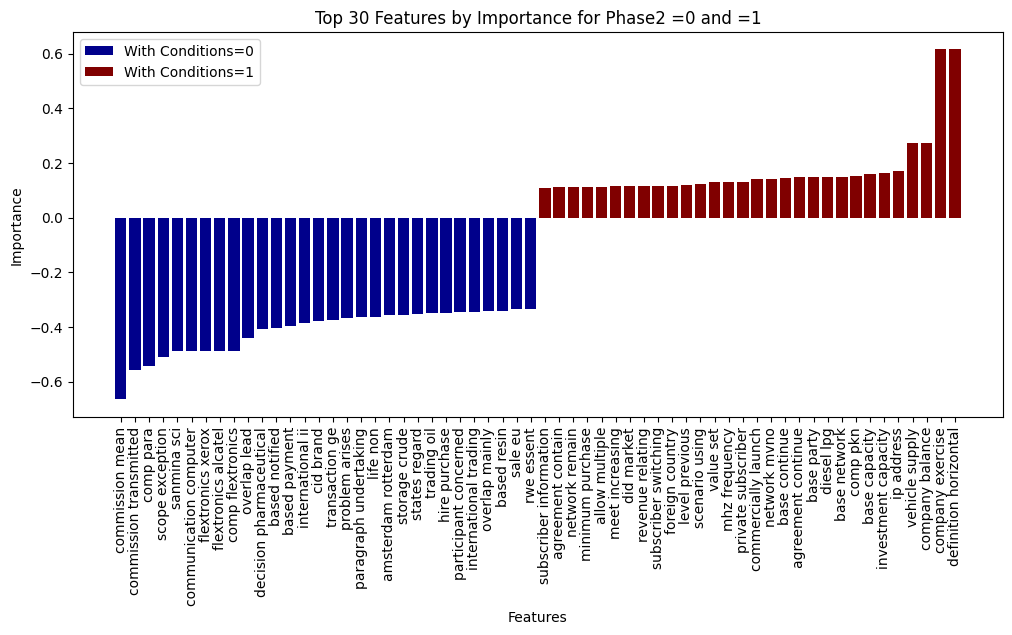

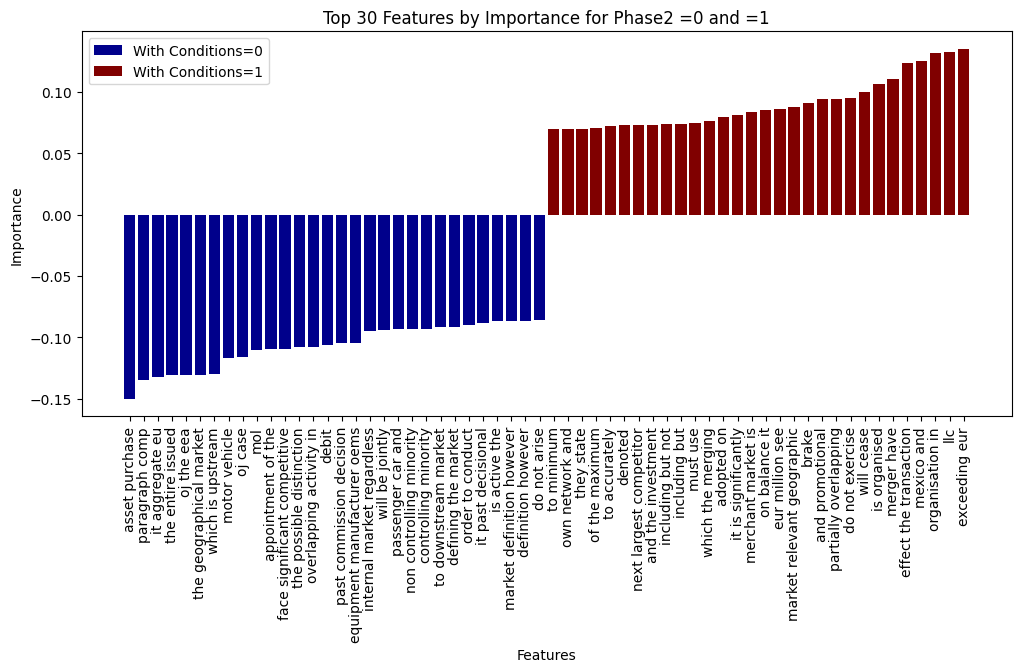

In [41]:
for i in range(0,2):  
    # Sort the features by absolute importance for label=1
    globals()[f"df_features_train1_{i}"] = globals()[f"df_features_train1_{i}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train1_top10_{i}"] = globals()[f"df_features_train1_{i}"].nlargest(30, 'abs_importance')
    globals()[f"df_features_train1_top10_{i}"] = globals()[f"df_features_train1_top10_{i}"].sort_values('importance', ascending=True)

    # Sort the features by absolute importance for label=0
    globals()[f"df_features_train0_{i}"] = globals()[f"df_features_train0_{i}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train0_top10_{i}"] = globals()[f"df_features_train0_{i}"].nlargest(30, 'abs_importance')

    # Create a combined bar chart
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(globals()[f"df_features_train0_top10_{i}"]['feature'], globals()[f"df_features_train0_top10_{i}"]['importance'], color='darkblue', label='With Conditions=0')
    ax.bar(globals()[f"df_features_train1_top10_{i}"]['feature'], globals()[f"df_features_train1_top10_{i}"]['importance'], color='maroon', label='With Conditions=1')
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    ax.set_title('Top 30 Features by Importance for Phase2 =0 and =1')
    ax.legend()
    plt.xticks(rotation=90)
    #plt.show()

    plt.savefig('../../output/robustness 1/svm_p2_robust_' + str(i) + '.png', bbox_inches='tight')

In [30]:
writer = pd.ExcelWriter('../../output/robustness/features_svm_p2_robust.xlsx', engine='xlsxwriter')

for i in range(0, 2):
    sheet_name = f"Sheet_{i}"
    df = globals()[f"df_features_train_{i}"]
    df = df.sort_values(by='importance', ascending=False)
    df.to_excel(writer, sheet_name=sheet_name, index=True)

writer.close()

### Confusion matrix and model performance

In [31]:
merger_info = pd.read_json(r"../../data/processed/merger_info_2023_03_25.json")

In [32]:
writer = pd.ExcelWriter('../../output/robustness/preds_svm_p2_robust.xlsx', engine='xlsxwriter')

for j, dataset_name in enumerate(['train', 'test1', 'test']):
    for i in range(0, 2):
        preds = pd.DataFrame(np.column_stack((globals()[f"X_{dataset_name}"], globals()[f"y_{dataset_name}"], globals()[f"y_predict_{dataset_name}_{i}"])), columns=['text', 'target', 'y_predict'])
        preds = pd.concat([globals()[f"df_{dataset_name}_grouped"], preds], axis=1)[['case_num', 'article', 'text', 'target', 'y_predict']]
        preds = pd.merge(preds, merger_info[['case_code', 'article', 'nace_code']], how='left', left_on=['case_num', 'article'], right_on=['case_code', 'article'])
        
        preds.loc[(preds.target == 0) & (preds.y_predict == 0), 'cm'] = 'tn'
        preds.loc[(preds.target == 0) & (preds.y_predict == 1), 'cm'] = 'fp'
        preds.loc[(preds.target == 1) & (preds.y_predict == 0), 'cm'] = 'fn'
        preds.loc[(preds.target == 1) & (preds.y_predict == 1), 'cm'] = 'tp'

        preds.to_excel(writer, sheet_name=f"preds_{dataset_name}_{i}", index=True)

writer.close()
